# MAKE GRID - NOTEBOOK VERSION

💡 This notebook allows the user to create a croco grid which will be used during the next steps of the preporcessing to add boundaries conditions and other forcings.  
In this notebook the user can edit the bathymetry and the mask (coastlines).  

See [online documentation](https://croco-ocean.gitlabpages.inria.fr/croco_pytools/prepro/tuto.grid.html) for more details 📚

## ✅📋 Dependencies
*Make sure to [build the croco_pyenv environment](https://croco-ocean.gitlabpages.inria.fr/croco_pytools/prepro/tuto.env.html) before using this notebook.*  

In [2]:
#Allows widget interactivity with user (activation of backend environments)
%matplotlib widget  
%load_ext autoreload
%autoreload 2

# Import standard modules
import os
import sys
import numpy as np

# Configure import paths
#os.environ['ETS_TOOLKIT'] = 'wx'
sys.path.extend(["./Modules/", "./Readers/", "./Modules/graphicUI_tools/"])

# Import third-party modules
import matplotlib.pyplot as plt
from scipy.spatial import distance
import ipywidgets as widgets
from ipywidgets import interact_manual, FloatText, VBox
from IPython.display import display

# Import custom modules
from tools_make_grid import inputs, inputs_smth, EasyGrid, GetMask, GetTopo
from croco_class import CROCO
from tools_grid_inputs import setup_widgets, prepare_variables
from tools_create_grids import create_classic_grid
from tools_grid_edition import (ValueUpdater, RectangleSelectorEdition,
                                MaskUpdater, plot_mask, RectangleSelectorMaskUpdater)

## ✏️🔧 User's changes

➡️ Launch the next python cell in order to display the widget which allows you to configurate your future main grid.  
Then click on the "SAVE" button each time you modify your configuration.  
🔎 Concerning the inputs, you'll need:
<table style="width: 100%; text-align: left; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">DATA</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">SOURCE</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">FILE EXTENSION</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>Topo/Bathy</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">etopo (5,2,1),<br>srtm30, gebco</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>Coastline</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">GSHHS</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>shapefile</em></td>
    </tr>
  </tbody>
</table>

In [3]:
# Call the setup_widgets function to display the widgets and get the function to retrieve saved values
get_config= setup_widgets(parent_grid=False)

## 🧩🌐 Building the grid

➡️ By running the next python cell, the configuration saved at the previous step is loaded, and a dictionnary nammed "variables" is extracted from it to run the grid-creation-code.

<div class="alert alert-block alert-warning"> 
Tip: if the ouput window is too long 🖱️ right click on the cell annd "Enable scrolling for outputs"
</div>

In [3]:
# Get the config paramaters defined in the widgets + retain the ones useful for creating the grid
saved_config= get_config()
variables= prepare_variables(saved_config)

# Create the grid and saves it in "grid", the configuration is saved in "inputs"
grid, inputs = create_classic_grid(**variables)

Reading topography file: ../../DATASETS_CROCOTOOLS/Topo/etopo2.nc
Single region dataset imin/imax= 5534 6165
Bounding indices of the relevant part to be extracted from the entire dataset:
 imin,imax = 5534 6165 out of 10800 jmin,jmax = 1528 1963 out of 5400
Interpolating topography to CROCO grid

 Geographical extents of the dataset:
    Longitude min/max =    4.466667   25.500000
    Latitude  min/max =  -39.066666  -24.566668

 Geographical extents of requested ROMS grid:
    Longitude min/max =    4.511359   25.488641
    Latitude  min/max =  -39.031434  -24.631671

 Bounding indices for the portion of dataset covering the entire model grid:
 iwest,ieast =    2   631 out of   632 jsouth,jnorth =    2   434 out of   436

 Averaging window width = 2.00000 in grid spaces.

.........

 Wall Clock time spent to compute hraw    0.03 sec running   1 threads.
Finished interpolating
 enter smooth_thread r_max = 0.2000000  iters_cond =  500  iters_lin =    0
 set_tiles: nx =  40 ny =  39 numt

## 👁️🌐 Grid display
Run the next cell to check the grid before saving it. To edit it, go to the next section.

<GeoAxes: >

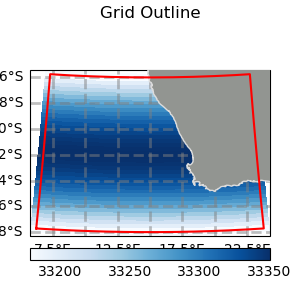

In [4]:
from Modules.map_tools.map_tools import plot_grid, plot_outline, plot_topo

plt.style.use('_mpl-gallery')
figure = plt.figure(figsize = (3,3))
ax = plot_outline(grid, figure)
figure.suptitle('Grid Outline')
#plot_grid(grid, figure, ax, saved_config['Files']['shp_file'], zview='topo',plot_shape = True)
plot_grid(grid, figure, ax, saved_config['Files']['shp_file'], zview='1/pn',plot_shape = True)

<div class="alert alert-block alert-info">
More Arguments:

- **4th argument**: path to the shape file
- **5th argument**: options (choose one):
  - *grid points*
  - *topo*
  - *1/pm*
  - *1/pn*
  - *angle*
  - *mask*
- **6th argument**: set to `True` to plot the shape or `False` to omit it

```python
plot_grid(outputs, figure, ax, shp_file, zview='grid outline', plot_shape=True)
```
</div>

##### 💾 Save grid as necdf
This code creates a Netcdf file containing all grid data (geographic, topo-bathymetric, mask) in the format defined by the classes generated earlier in this notebook.   
Then it saves it in the ouput repertory. If you want to edit bathymetry/Mask you can save it later on this notebook.

In [100]:
CROCO.create_grid_nc(None, saved_config['Files']['output_file'], inputs, grid)

Writting ../../CROCO_FILES/croco_grd.nc done


## ✏️ MASK and BATHYMETRY edition

### Editing bathymetry

#### Cell by cell edition mode
Launch the next cell to edit the grid bathymetry cell by cell.  
➡️ Click on a mesh, edit its value and then save it. Start again if necessary.

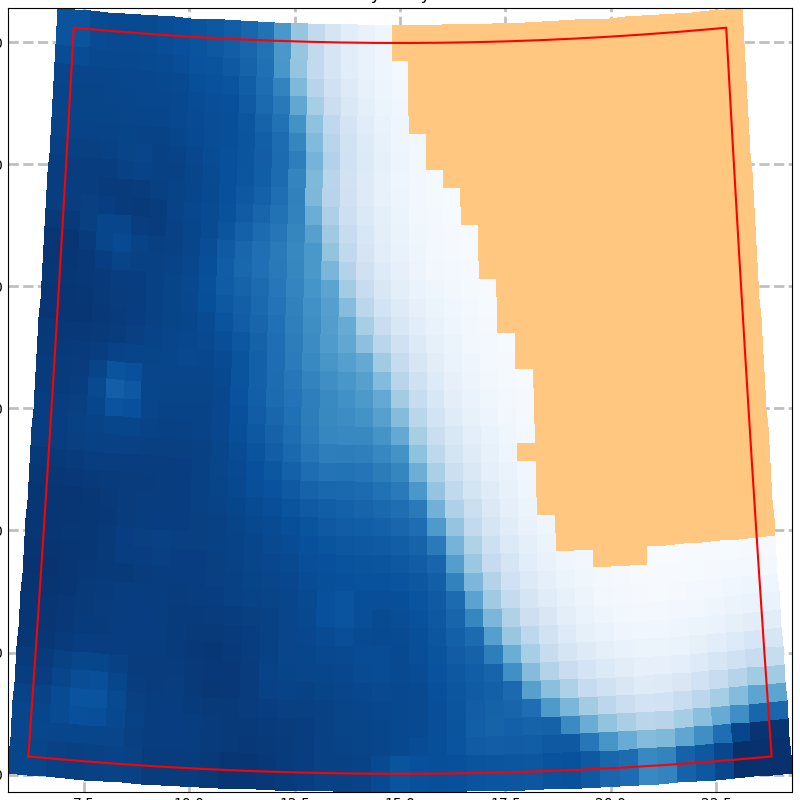

In [24]:
#Create an instance of the class ValueUpdater (Value of the Topo)
figure_cell_updater= ValueUpdater(grid)

#### Rectangle selector edition mode
To edit multiple cells at once, you can display the "Rectangle Selector Widget" below by running the cell.  
➡️ Click and hold to expand the rectangle. After releasing the click, enter the new value and save it.

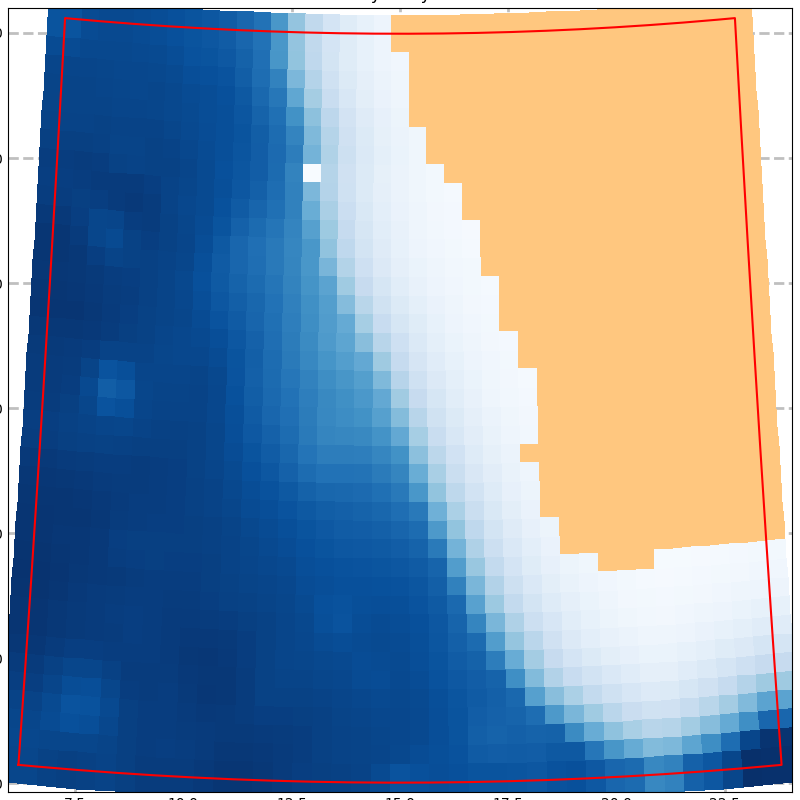

In [25]:
figure_cell_updater= RectangleSelectorEdition(grid)

### Editing the MASK

#### Cell by cell edition mode
Launch the next cell to edit the grid mask (initially based on coastlines shapefile) cell by cell.  
➡️ Click on a mesh, edit its value and then save it. Start again if necessary.

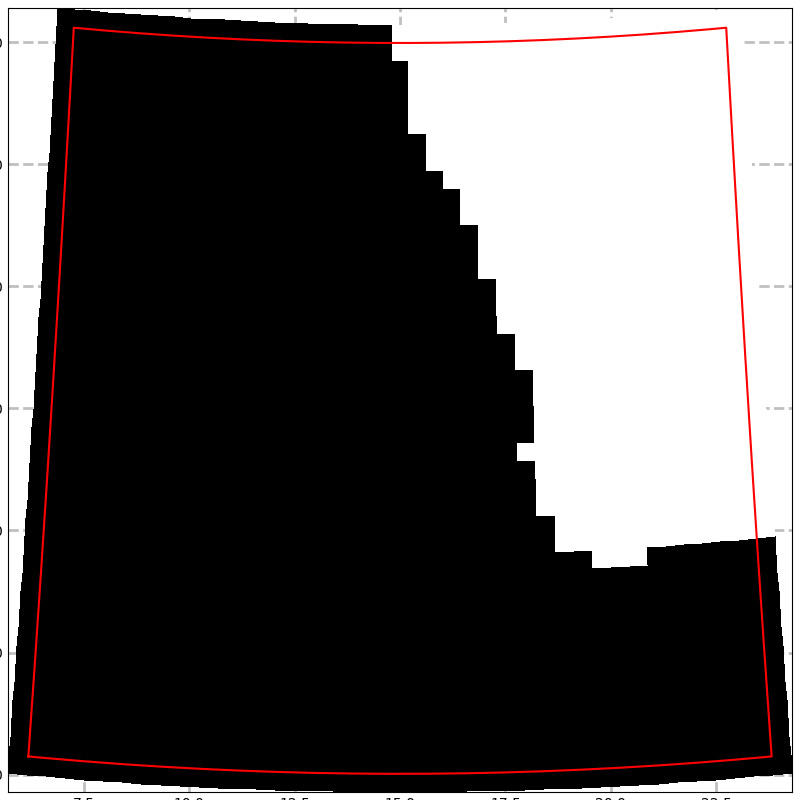

In [26]:
#Create an instance of the class MaskUpdater
figure_maskcell_updater= MaskUpdater(grid)

#### Rectangle selector edition mode

To edit multiple cells at once, you can display the "Rectangle Selector Widget" below by running the cell.  
➡️ Click and hold to expand the rectangle. After releasing the click, enter the new value and save it.

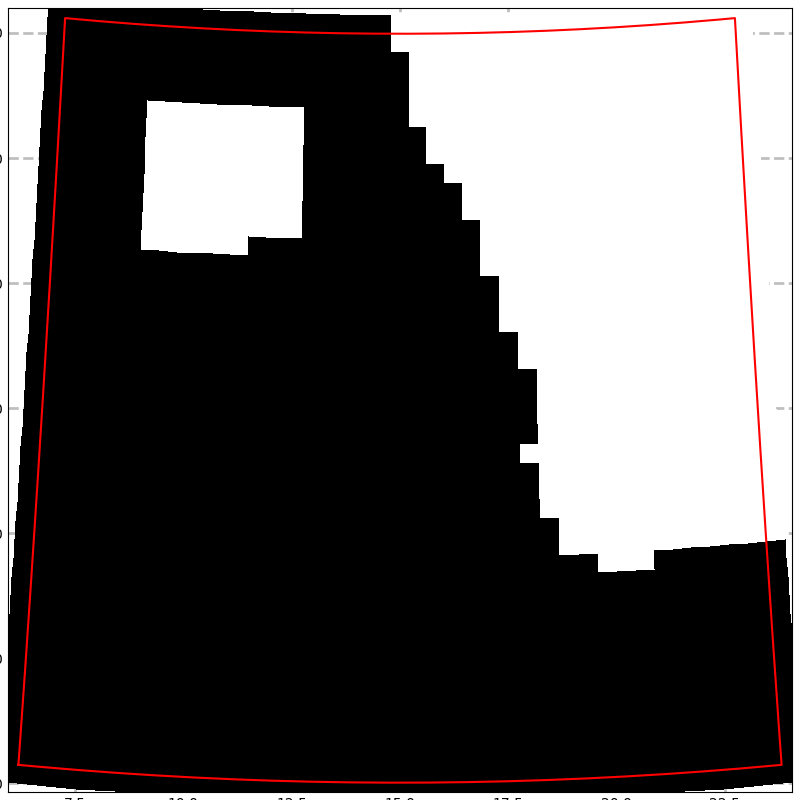

In [9]:
figure_maskrect_updater= RectangleSelectorMaskUpdater(grid)

##### 💾 Save grid as necdf
This code creates a Netcdf file containing all grid data (geographic, topo-bathymetric, mask) in the format defined by the classes generated earlier in this notebook.   
Then it saves it in the ouput repertory. If you want to edit bathymetry/Mask you can save it later on this notebook.

In [ ]:
CROCO.create_grid_nc(None, saved_config['Files']['output_file'], inputs, grid)